In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from os import chdir
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Embedding, GRU
from tensorflow.keras.layers import Dropout

from sklearn.model_selection import train_test_split

import pickle
from IPython.display import clear_output

In [2]:
#планируется словарь алгоритмов для более быстрого создания всех датафреймов
alg_dict = {'sort': ['bubble_sort', 'quick_sort','selection_sort','merge_sort','insertion_sort'], 'find': ['binary_search','linear_search','quick_select']}

In [3]:
#создание датафрейма
def make_df():
    df = pd.read_csv('csv/dataset_5_sort_3_find.csv')
    df = df.set_index('filename')
    del df['Unnamed: 0']
    return df

In [4]:
def classification_sort(df):
    df = df[df['algorithm'] == 'sort']
    sort_class = []
    for language,algorithm,algorithm_name in zip(df['language'],df['algorithm'],df['algorithm_name']):
        algorithm_name = algorithm_name.strip()
        if algorithm_name == 'bubble_sort':
            sort_class.append([1,0,0,0,0])
        if algorithm_name == 'quick_sort':
            sort_class.append([0,1,0,0,0])
        if algorithm_name == 'selection_sort':
            sort_class.append([0,0,1,0,0])
        if algorithm_name == 'merge_sort':
            sort_class.append([0,0,0,1,0])
        if algorithm_name == 'insertion_sort':
            sort_class.append([0,0,0,0,1])
    return df, np.array(sort_class)

In [5]:
def classification_bubble_and_select(df):
    df = df[df['algorithm_name'].isin(['bubble_sort', 'selection_sort'])]
    sort_class = []
    for algorithm_name in df['algorithm_name']:
        algorithm_name = algorithm_name.strip()
        if algorithm_name == 'bubble_sort':
            sort_class.append([1, 0])
        elif algorithm_name == 'selection_sort':
            sort_class.append([0, 1])
    return df, np.array(sort_class)

In [6]:
def classification_find(df):
    df = df[df['algorithm'] == 'find']
    find_class = []
    for language,algorithm,algorithm_name in zip(df['language'],df['algorithm'],df['algorithm_name']):
        algorithm_name = algorithm_name.strip()
        if algorithm_name == 'binary_search':
            find_class.append([1,0,0])
        if algorithm_name == 'quick_select':
            find_class.append([0,1,0])
        if algorithm_name == 'linear_search':
            find_class.append([0,0,1])
        
    return df, np.array(find_class)

In [7]:
def file_read(df):
    new_lines = []
    for index, row in df.iterrows():
        chdir(f'dataset/{row[1]}/{row[2]}')
        with open(str(index),'r', encoding = 'utf-8') as f:
            lines = f.readlines()
            lines = [line for line in lines if line.strip() != ""]
        %cd ../../..
        new_lines.append(lines)
    #%cd ../..
    return new_lines

In [8]:
#обработка переменной без табов, заменяя их на 2 пробела (Доработать)
def preporcessing_files(lines):
    new_lines = []
    code_line = ''
    for i in lines:
        for j in i:
            j = j.replace('    ', ' ')
            code_line += j
        new_lines.append(code_line)
        code_line = ''
    return new_lines

In [9]:
df = make_df()

In [10]:
#Для сортировки
df_sort, classes_sort = classification_sort(df)
files_sort = file_read(df_sort)
pre_files_sort = preporcessing_files(files_sort)
clear_output()

In [11]:
#Для поиска
df_find, classes_find = classification_find(df)
files_find = file_read(df_find)
pre_files_find = preporcessing_files(files_find)
clear_output()

In [13]:
#Для бинарной классификации сортировок
df_sort_bin, classes_sort_bin = classification_sort(df)
files_sort_bin = file_read(df_sort_bin)
pre_files_sort_bin = preporcessing_files(files_sort_bin)
clear_output()

# Основная часть, построение архитектуры

In [212]:
maxWord = 50
max_text_len = 50
tokenizer = Tokenizer(num_words=maxWord, lower = True, split = ' ', char_level=False)
tokenizer.fit_on_texts(pre_files_sort) #Меняем данные
data = tokenizer.texts_to_sequences(pre_files_sort) #Меняем данные 
data_pad = pad_sequences(data,maxlen = max_text_len)
X = data_pad
Y = classes_sort # меняем данные

In [213]:
# with open('files\\new_sort_5.pickle', 'wb') as file:
#     pickle.dump(pre_files_sort, file) # Меняем данные

In [214]:
len(data_pad) == len(X) == len(Y) == len(classes_sort) #Меняем данные

True

In [215]:
X[106]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14, 33,  3, 11,  8,  3,  2,
       10,  3,  3, 10, 33, 33, 14,  3, 11,  3, 10, 19,  3, 21, 19, 18, 31,
       17,  3,  2, 11, 31, 19, 35, 31, 31, 19, 35, 31, 45, 35, 31, 10])

In [239]:
model = Sequential([
    Embedding(maxWord, 128, input_length = max_text_len),
    LSTM(128, return_sequences=True),
    LSTM(32, return_sequences=True),
    LSTM(8),
    Dense(5, activation='softmax')
])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 128)           6400      
_________________________________________________________________
lstm_16 (LSTM)               (None, 50, 128)           131584    
_________________________________________________________________
lstm_17 (LSTM)               (None, 50, 32)            20608     
_________________________________________________________________
lstm_18 (LSTM)               (None, 8)                 1312      
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 45        
Total params: 159,949
Trainable params: 159,949
Non-trainable params: 0
_________________________________________________________________


In [240]:
model.compile(loss ='categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(0.0001))

In [256]:
train_data, val_data, train_class, val_class = train_test_split(X,Y, test_size=0.2)

In [257]:
print(np.sum(np.all(val_class == np.array([0,0,0,0,1]), axis=1)))
print(np.sum(np.all(val_class == np.array([0,0,0,1,0]), axis=1)))
print(np.sum(np.all(val_class == np.array([0,0,1,0,0]), axis=1)))
print(np.sum(np.all(val_class == np.array([0,1,0,0,0]), axis=1)))
print(np.sum(np.all(val_class == np.array([1,0,0,0,0]), axis=1)))

20
20
21
21
20


In [255]:
# print(np.sum(np.all(val_class == np.array([0,0,1]), axis=1)))
# print(np.sum(np.all(val_class == np.array([0,1,0]), axis=1)))
# print(np.sum(np.all(val_class == np.array([1,0,0]), axis=1)))

In [258]:
history = model.fit(train_data,train_class, validation_data=(val_data,val_class), batch_size = 1024, epochs = 500)

Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 1.6090 - accuracy: 0.1535 - val_loss: 1.6080 - val_accuracy: 0.2255
Epoch 2/1000
1/1 [==============================] - 0s 181ms/step - loss: 1.6080 - accuracy: 0.2450 - val_loss: 1.6070 - val_accuracy: 0.2745
Epoch 3/1000
1/1 [==============================] - 0s 129ms/step - loss: 1.6070 - accuracy: 0.2921 - val_loss: 1.6059 - val_accuracy: 0.3529
Epoch 4/1000
1/1 [==============================] - 0s 49ms/step - loss: 1.6059 - accuracy: 0.3564 - val_loss: 1.6048 - val_accuracy: 0.3725
Epoch 5/1000
1/1 [==============================] - 0s 48ms/step - loss: 1.6049 - accuracy: 0.3911 - val_loss: 1.6038 - val_accuracy: 0.4020
Epoch 6/1000
1/1 [==============================] - 0s 48ms/step - loss: 1.6038 - accuracy: 0.4579 - val_loss: 1.6027 - val_accuracy: 0.4412
Epoch 7/1000
1/1 [==============================] - 0s 45ms/step - loss: 1.6028 - accuracy: 0.4802 - val_loss: 1.6016 - val_accuracy: 0.4608
Epoch 8/1000


Epoch 59/1000
1/1 [==============================] - 0s 46ms/step - loss: 1.4077 - accuracy: 0.5322 - val_loss: 1.3975 - val_accuracy: 0.5098
Epoch 60/1000
1/1 [==============================] - 0s 47ms/step - loss: 1.3991 - accuracy: 0.5272 - val_loss: 1.3891 - val_accuracy: 0.5000
Epoch 61/1000
1/1 [==============================] - 0s 45ms/step - loss: 1.3908 - accuracy: 0.5223 - val_loss: 1.3810 - val_accuracy: 0.5000
Epoch 62/1000
1/1 [==============================] - 0s 48ms/step - loss: 1.3827 - accuracy: 0.5149 - val_loss: 1.3731 - val_accuracy: 0.5000
Epoch 63/1000
1/1 [==============================] - 0s 47ms/step - loss: 1.3750 - accuracy: 0.5099 - val_loss: 1.3653 - val_accuracy: 0.5000
Epoch 64/1000
1/1 [==============================] - 0s 47ms/step - loss: 1.3674 - accuracy: 0.5050 - val_loss: 1.3577 - val_accuracy: 0.5196
Epoch 65/1000
1/1 [==============================] - 0s 49ms/step - loss: 1.3599 - accuracy: 0.5074 - val_loss: 1.3501 - val_accuracy: 0.5294
Epoch 

1/1 [==============================] - 0s 50ms/step - loss: 1.0148 - accuracy: 0.7475 - val_loss: 1.0090 - val_accuracy: 0.7647
Epoch 117/1000
1/1 [==============================] - 0s 52ms/step - loss: 1.0102 - accuracy: 0.7500 - val_loss: 1.0038 - val_accuracy: 0.7647
Epoch 118/1000
1/1 [==============================] - 0s 51ms/step - loss: 1.0056 - accuracy: 0.7500 - val_loss: 0.9989 - val_accuracy: 0.7647
Epoch 119/1000
1/1 [==============================] - 0s 51ms/step - loss: 1.0011 - accuracy: 0.7525 - val_loss: 0.9936 - val_accuracy: 0.7647
Epoch 120/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.9966 - accuracy: 0.7550 - val_loss: 0.9876 - val_accuracy: 0.7647
Epoch 121/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.9920 - accuracy: 0.7574 - val_loss: 0.9816 - val_accuracy: 0.7647
Epoch 122/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.9876 - accuracy: 0.7574 - val_loss: 0.9763 - val_accuracy: 0.7647
Epoch 123/1000

1/1 [==============================] - 0s 53ms/step - loss: 0.7944 - accuracy: 0.7698 - val_loss: 0.8140 - val_accuracy: 0.7647
Epoch 174/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.7914 - accuracy: 0.7698 - val_loss: 0.8128 - val_accuracy: 0.7647
Epoch 175/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.7886 - accuracy: 0.7748 - val_loss: 0.8090 - val_accuracy: 0.7647
Epoch 176/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.7858 - accuracy: 0.7723 - val_loss: 0.8115 - val_accuracy: 0.7647
Epoch 177/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.7839 - accuracy: 0.7748 - val_loss: 0.8061 - val_accuracy: 0.7647
Epoch 178/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.7873 - accuracy: 0.7649 - val_loss: 0.8166 - val_accuracy: 0.7647
Epoch 179/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.7854 - accuracy: 0.7748 - val_loss: 0.8032 - val_accuracy: 0.7647
Epoch 180/1000

1/1 [==============================] - 0s 50ms/step - loss: 0.6872 - accuracy: 0.7995 - val_loss: 0.7260 - val_accuracy: 0.7843
Epoch 231/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.6856 - accuracy: 0.7995 - val_loss: 0.7229 - val_accuracy: 0.7843
Epoch 232/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.6846 - accuracy: 0.7946 - val_loss: 0.7261 - val_accuracy: 0.7843
Epoch 233/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.6833 - accuracy: 0.7995 - val_loss: 0.7182 - val_accuracy: 0.7843
Epoch 234/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.6836 - accuracy: 0.7946 - val_loss: 0.7216 - val_accuracy: 0.7843
Epoch 235/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.6797 - accuracy: 0.8020 - val_loss: 0.7266 - val_accuracy: 0.7941
Epoch 236/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.6835 - accuracy: 0.7970 - val_loss: 0.7302 - val_accuracy: 0.7647
Epoch 237/1000

1/1 [==============================] - 0s 53ms/step - loss: 0.6066 - accuracy: 0.8713 - val_loss: 0.6275 - val_accuracy: 0.8529
Epoch 288/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.6047 - accuracy: 0.8688 - val_loss: 0.6244 - val_accuracy: 0.8627
Epoch 289/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.6031 - accuracy: 0.8713 - val_loss: 0.6235 - val_accuracy: 0.8529
Epoch 290/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.6010 - accuracy: 0.8837 - val_loss: 0.6228 - val_accuracy: 0.8725
Epoch 291/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.5994 - accuracy: 0.8886 - val_loss: 0.6198 - val_accuracy: 0.8824
Epoch 292/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.5973 - accuracy: 0.8960 - val_loss: 0.6185 - val_accuracy: 0.8824
Epoch 293/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.5956 - accuracy: 0.8960 - val_loss: 0.6184 - val_accuracy: 0.8922
Epoch 294/1000

1/1 [==============================] - 0s 53ms/step - loss: 0.5148 - accuracy: 0.9604 - val_loss: 0.5529 - val_accuracy: 0.9314
Epoch 345/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.5132 - accuracy: 0.9604 - val_loss: 0.5450 - val_accuracy: 0.9314
Epoch 346/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.5091 - accuracy: 0.9604 - val_loss: 0.5385 - val_accuracy: 0.9412
Epoch 347/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.5088 - accuracy: 0.9604 - val_loss: 0.5341 - val_accuracy: 0.9412
Epoch 348/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.5061 - accuracy: 0.9629 - val_loss: 0.5340 - val_accuracy: 0.9412
Epoch 349/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.5063 - accuracy: 0.9629 - val_loss: 0.5288 - val_accuracy: 0.9510
Epoch 350/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.5027 - accuracy: 0.9653 - val_loss: 0.5266 - val_accuracy: 0.9510
Epoch 351/1000

1/1 [==============================] - 0s 58ms/step - loss: 0.4455 - accuracy: 0.9802 - val_loss: 0.4813 - val_accuracy: 0.9608
Epoch 402/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.4445 - accuracy: 0.9802 - val_loss: 0.4803 - val_accuracy: 0.9608
Epoch 403/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.4434 - accuracy: 0.9802 - val_loss: 0.4790 - val_accuracy: 0.9608
Epoch 404/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.4425 - accuracy: 0.9802 - val_loss: 0.4784 - val_accuracy: 0.9608
Epoch 405/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.4415 - accuracy: 0.9802 - val_loss: 0.4776 - val_accuracy: 0.9608
Epoch 406/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.4405 - accuracy: 0.9802 - val_loss: 0.4764 - val_accuracy: 0.9608
Epoch 407/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.4394 - accuracy: 0.9802 - val_loss: 0.4757 - val_accuracy: 0.9608
Epoch 408/1000

1/1 [==============================] - 0s 56ms/step - loss: 0.3925 - accuracy: 0.9876 - val_loss: 0.4314 - val_accuracy: 0.9608
Epoch 459/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3915 - accuracy: 0.9876 - val_loss: 0.4311 - val_accuracy: 0.9608
Epoch 460/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.3908 - accuracy: 0.9876 - val_loss: 0.4295 - val_accuracy: 0.9608
Epoch 461/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.3902 - accuracy: 0.9876 - val_loss: 0.4307 - val_accuracy: 0.9608
Epoch 462/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3895 - accuracy: 0.9876 - val_loss: 0.4283 - val_accuracy: 0.9608
Epoch 463/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.3888 - accuracy: 0.9876 - val_loss: 0.4291 - val_accuracy: 0.9608
Epoch 464/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.3880 - accuracy: 0.9876 - val_loss: 0.4263 - val_accuracy: 0.9608
Epoch 465/1000

1/1 [==============================] - 0s 51ms/step - loss: 0.3975 - accuracy: 0.9629 - val_loss: 0.3984 - val_accuracy: 0.9706
Epoch 516/1000
1/1 [==============================] - 0s 47ms/step - loss: 0.3615 - accuracy: 0.9851 - val_loss: 0.3981 - val_accuracy: 0.9608
Epoch 517/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.3597 - accuracy: 0.9876 - val_loss: 0.3938 - val_accuracy: 0.9706
Epoch 518/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.3618 - accuracy: 0.9851 - val_loss: 0.3960 - val_accuracy: 0.9706
Epoch 519/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.3635 - accuracy: 0.9827 - val_loss: 0.3955 - val_accuracy: 0.9706
Epoch 520/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.3582 - accuracy: 0.9827 - val_loss: 0.3975 - val_accuracy: 0.9706
Epoch 521/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3555 - accuracy: 0.9901 - val_loss: 0.3905 - val_accuracy: 0.9706
Epoch 522/1000

1/1 [==============================] - 0s 55ms/step - loss: 0.3167 - accuracy: 0.9901 - val_loss: 0.3624 - val_accuracy: 0.9608
Epoch 573/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3170 - accuracy: 0.9901 - val_loss: 0.3572 - val_accuracy: 0.9706
Epoch 574/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3144 - accuracy: 0.9901 - val_loss: 0.3563 - val_accuracy: 0.9706
Epoch 575/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.3158 - accuracy: 0.9876 - val_loss: 0.3602 - val_accuracy: 0.9608
Epoch 576/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.3146 - accuracy: 0.9901 - val_loss: 0.3613 - val_accuracy: 0.9608
Epoch 577/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.3160 - accuracy: 0.9901 - val_loss: 0.3557 - val_accuracy: 0.9706
Epoch 578/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3124 - accuracy: 0.9901 - val_loss: 0.3552 - val_accuracy: 0.9706
Epoch 579/1000

1/1 [==============================] - 0s 54ms/step - loss: 0.2880 - accuracy: 0.9901 - val_loss: 0.3566 - val_accuracy: 0.9608
Epoch 630/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.2884 - accuracy: 0.9901 - val_loss: 0.3578 - val_accuracy: 0.9608
Epoch 631/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.2872 - accuracy: 0.9901 - val_loss: 0.3584 - val_accuracy: 0.9510
Epoch 632/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.2872 - accuracy: 0.9901 - val_loss: 0.3582 - val_accuracy: 0.9608
Epoch 633/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.2864 - accuracy: 0.9901 - val_loss: 0.3572 - val_accuracy: 0.9608
Epoch 634/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.2863 - accuracy: 0.9901 - val_loss: 0.3580 - val_accuracy: 0.9608
Epoch 635/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.2855 - accuracy: 0.9901 - val_loss: 0.3588 - val_accuracy: 0.9510
Epoch 636/1000

1/1 [==============================] - 0s 52ms/step - loss: 0.2660 - accuracy: 0.9901 - val_loss: 0.3493 - val_accuracy: 0.9510
Epoch 687/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.2657 - accuracy: 0.9901 - val_loss: 0.3491 - val_accuracy: 0.9510
Epoch 688/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.2654 - accuracy: 0.9901 - val_loss: 0.3488 - val_accuracy: 0.9510
Epoch 689/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.2650 - accuracy: 0.9901 - val_loss: 0.3484 - val_accuracy: 0.9510
Epoch 690/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.2647 - accuracy: 0.9901 - val_loss: 0.3483 - val_accuracy: 0.9510
Epoch 691/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.2643 - accuracy: 0.9901 - val_loss: 0.3481 - val_accuracy: 0.9510
Epoch 692/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.2640 - accuracy: 0.9901 - val_loss: 0.3477 - val_accuracy: 0.9510
Epoch 693/1000

1/1 [==============================] - 0s 47ms/step - loss: 0.2486 - accuracy: 0.9901 - val_loss: 0.3351 - val_accuracy: 0.9510
Epoch 744/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.2483 - accuracy: 0.9901 - val_loss: 0.3348 - val_accuracy: 0.9510
Epoch 745/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.2481 - accuracy: 0.9901 - val_loss: 0.3346 - val_accuracy: 0.9510
Epoch 746/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.2477 - accuracy: 0.9901 - val_loss: 0.3344 - val_accuracy: 0.9510
Epoch 747/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.2475 - accuracy: 0.9901 - val_loss: 0.3342 - val_accuracy: 0.9510
Epoch 748/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.2472 - accuracy: 0.9901 - val_loss: 0.3339 - val_accuracy: 0.9510
Epoch 749/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.2469 - accuracy: 0.9901 - val_loss: 0.3339 - val_accuracy: 0.9510
Epoch 750/1000

1/1 [==============================] - 0s 57ms/step - loss: 0.2340 - accuracy: 0.9901 - val_loss: 0.3234 - val_accuracy: 0.9608
Epoch 801/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.2338 - accuracy: 0.9901 - val_loss: 0.3231 - val_accuracy: 0.9608
Epoch 802/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.2335 - accuracy: 0.9901 - val_loss: 0.3229 - val_accuracy: 0.9608
Epoch 803/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.2333 - accuracy: 0.9901 - val_loss: 0.3229 - val_accuracy: 0.9608
Epoch 804/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.2331 - accuracy: 0.9901 - val_loss: 0.3227 - val_accuracy: 0.9608
Epoch 805/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.2328 - accuracy: 0.9901 - val_loss: 0.3224 - val_accuracy: 0.9608
Epoch 806/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.2326 - accuracy: 0.9901 - val_loss: 0.3223 - val_accuracy: 0.9608
Epoch 807/1000

1/1 [==============================] - 0s 50ms/step - loss: 0.2214 - accuracy: 0.9901 - val_loss: 0.3137 - val_accuracy: 0.9608
Epoch 858/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.2212 - accuracy: 0.9901 - val_loss: 0.3135 - val_accuracy: 0.9608
Epoch 859/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.2210 - accuracy: 0.9901 - val_loss: 0.3135 - val_accuracy: 0.9608
Epoch 860/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.2207 - accuracy: 0.9901 - val_loss: 0.3131 - val_accuracy: 0.9608
Epoch 861/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.2206 - accuracy: 0.9901 - val_loss: 0.3131 - val_accuracy: 0.9608
Epoch 862/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.2204 - accuracy: 0.9901 - val_loss: 0.3130 - val_accuracy: 0.9608
Epoch 863/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.2201 - accuracy: 0.9901 - val_loss: 0.3128 - val_accuracy: 0.9608
Epoch 864/1000

1/1 [==============================] - 0s 55ms/step - loss: 0.2102 - accuracy: 0.9901 - val_loss: 0.3039 - val_accuracy: 0.9608
Epoch 915/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.2100 - accuracy: 0.9901 - val_loss: 0.3035 - val_accuracy: 0.9608
Epoch 916/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.2098 - accuracy: 0.9901 - val_loss: 0.3040 - val_accuracy: 0.9608
Epoch 917/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.2096 - accuracy: 0.9901 - val_loss: 0.3034 - val_accuracy: 0.9608
Epoch 918/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.2094 - accuracy: 0.9901 - val_loss: 0.3033 - val_accuracy: 0.9608
Epoch 919/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.2092 - accuracy: 0.9901 - val_loss: 0.3037 - val_accuracy: 0.9608
Epoch 920/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.2091 - accuracy: 0.9901 - val_loss: 0.3030 - val_accuracy: 0.9608
Epoch 921/1000

1/1 [==============================] - 0s 49ms/step - loss: 0.2000 - accuracy: 0.9901 - val_loss: 0.2968 - val_accuracy: 0.9608
Epoch 972/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.1998 - accuracy: 0.9901 - val_loss: 0.2968 - val_accuracy: 0.9608
Epoch 973/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.1997 - accuracy: 0.9901 - val_loss: 0.2966 - val_accuracy: 0.9608
Epoch 974/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.1995 - accuracy: 0.9901 - val_loss: 0.2966 - val_accuracy: 0.9608
Epoch 975/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.1994 - accuracy: 0.9901 - val_loss: 0.2965 - val_accuracy: 0.9608
Epoch 976/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.1992 - accuracy: 0.9901 - val_loss: 0.2963 - val_accuracy: 0.9608
Epoch 977/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.1990 - accuracy: 0.9901 - val_loss: 0.2963 - val_accuracy: 0.9608
Epoch 978/1000

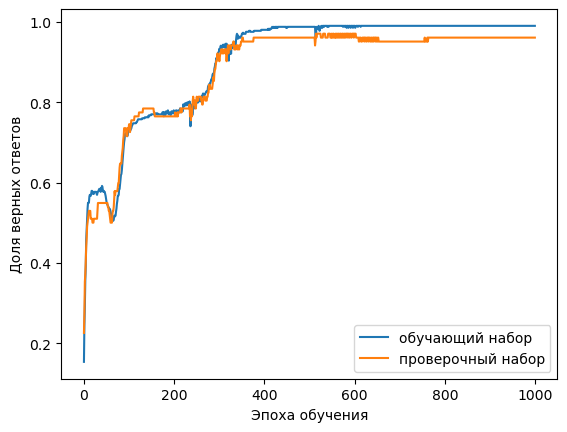

In [259]:
plt.plot(history.history['accuracy'],
         label='обучающий набор')
plt.plot(history.history['val_accuracy'],
         label='проверочный набор')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Тест моделей

In [260]:
def test_model(text,max_text_len = max_text_len,model=model):
    test_text = text.lower()
    data_test = tokenizer.texts_to_sequences([test_text])
    data_pad_test = pad_sequences(data_test, maxlen = max_text_len)
    res = model.predict(data_pad_test)
    return res, np.argmax(res)

In [271]:
test_model("""
    def bubble_sort(arr):
        n = len(arr)
        for i in range(n):
            for j in range(0, n - i - 1):
                if arr[j] > arr[j + 1]:
                    arr[j], arr[j + 1] = arr[j + 1], arr[j]
            """)

(array([[0.7303263 , 0.13760057, 0.01794833, 0.03906905, 0.07505581]],
       dtype=float32),
 0)

In [262]:
test_model("""
    def bubble_sort(array):
        len = len(array)
        for n in range(len):
            for k in range(0, len - n - 1):
                if array[k] > array[k + 1]:
                    array[k], array[k + 1] = array[k + 1], array[k]
            """)

(array([[0.7429699 , 0.1643642 , 0.00989662, 0.0376676 , 0.04510168]],
       dtype=float32),
 0)

In [263]:
test_model("""
def QuickSort(A):
    if len(A) <= 1:
        return A
    else:
        q = random.choice(A)
        L = []
        M = []
        R = []
        for elem in A:
            if elem < q:
                L.append(elem) 
            elif elem > q: 
                R.append(elem) 
            else: 
                M.append(elem)
        return QuickSort(L) + M + QuickSort(R)
            """)

(array([[0.16505702, 0.78498065, 0.00862841, 0.03018214, 0.01115172]],
       dtype=float32),
 1)

In [270]:
test_model("""
    def selection_sort(arr):        
        for i in range(len(arr)):
            minimum = i
            for j in range(i + 1, len(arr)):
                if arr[j] < arr[minimum]:
                    minimum = j
            arr[minimum], arr[i] = arr[i], arr[minimum]
        return arr
            """)

(array([[0.30060494, 0.02491053, 0.1114829 , 0.05009313, 0.5129085 ]],
       dtype=float32),
 4)

In [265]:
test_model("""
    import operator
    def merge_sort(L, compare=operator.lt):
        if len(L) < 2:
            return L[:]
        else:
            middle = int(len(L) / 2)
            left = merge_sort(L[:middle], compare)
            right = merge_sort(L[middle:], compare)
            return merge(left, right, compare)

            def merge(left, right, compare):
        result = []
        i, j = 0, 0
        while i < len(left) and j < len(right):
            if compare(left[i], right[j]):
                result.append(left[i])
                i += 1
            else:
                result.append(right[j])
                j += 1
        while i < len(left):
            result.append(left[i])
            i += 1
        while j < len(right):
            result.append(right[j])
            j += 1
        return result
            """)

(array([[0.02931589, 0.03772069, 0.04269855, 0.8607615 , 0.02950334]],
       dtype=float32),
 3)

In [266]:
test_model("""
def partition(arr, low, high):
    pivot = arr[high]
    i = low - 1
    
    for j in range(low, high):
        if arr[j] <= pivot:
            i += 1
            arr[i], arr[j] = arr[j], arr[i]

    arr[i + 1], arr[high] = arr[high], arr[i + 1]
    return i + 1

def quicksort(arr, low=0, high=None):
    if high is None:
        high = len(arr) - 1

    if low < high:
        pivot_index = partition(arr, low, high)

        quicksort(arr, low, pivot_index - 1)
        quicksort(arr, pivot_index + 1, high)

    return arr

    """)

(array([[0.16127342, 0.7869367 , 0.00925862, 0.03166679, 0.01086446]],
       dtype=float32),
 1)

In [267]:
test_model("""def selection_sort(arr):        
    for i in range(len(arr)):
        minimum = i
        for j in range(i + 1, len(arr)):
            if arr[j] < arr[minimum]:
                minimum = j
        arr[minimum], arr[i] = arr[i], arr[minimum]
    return arr""")

(array([[0.30060494, 0.02491053, 0.1114829 , 0.05009313, 0.5129085 ]],
       dtype=float32),
 4)

In [268]:
test_model("""def quicksort(arr):
        if len(arr) <= 1:
            return arr
        else:
            pivot = arr[0]
            less = [x for x in arr[1:] if x <= pivot]
            greater = [x for x in arr[1:] if x > pivot]
            return quicksort(less) + [pivot] + quicksort(greater)
            """)

(array([[0.16403522, 0.7862317 , 0.00864909, 0.02997981, 0.0111041 ]],
       dtype=float32),
 1)

In [59]:
# model.save('models\\sort.h5')
# maxWord = 250
# max_text_len = 70

In [269]:
model.save('models\\5_sort_bug.h5')
# maxWord = 50
# max_text_len = 50

# Вспомогательные функции

In [19]:
pwd

'C:\\Users\\Matvey\\Анализ кода\\Code-Insight\\dataset'

In [22]:
%cd Анализ кода/Code-Insight

C:\Users\Matvey\Анализ кода\Code-Insight


In [18]:
%cd ../..

C:\Users\Matvey\Анализ кода\Code-Insight\dataset


In [20]:
%cd ../

C:\Users\Matvey\Анализ кода\Code-Insight


In [ ]:
%cd ../../..